In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing the required libraries**

In [30]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import train_test_split
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data.sampler import SequentialSampler
from pydicom import dcmread

import torch
from torchvision import transforms
from torchvision import transforms as T
import torch.nn as nn
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pydicom as pyd
from tqdm import tqdm

import cv2
import re
import time
import matplotlib
import os

from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
import albumentations as A

from albumentations import (
    Resize,
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

# **Reading the input files**

In [31]:
images_path = 'data/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_labels_df = pd.read_csv('data/rsna-pneumonia-detection-challenge/stage_2_train_labels_dropped.csv')
label_meta_data = pd.read_csv('data/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

In [32]:
train_labels_df

,patientId,x,y,width,height,Target
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
1,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
2,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
3,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
4,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
...,...,...,...,...,...,...
9550,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1
9551,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
9552,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
9553,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [33]:
label_meta_data

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [34]:
len(np.unique(label_meta_data['patientId']))

26684

In [35]:
label_meta_data.shape

(30227, 2)

# **Target Distribution**

In [36]:
unique_patientId = train_labels_df.drop_duplicates(subset = ['patientId'])
unique_patientId

,patientId,x,y,width,height,Target
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
2,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
4,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
6,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1
8,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1
...,...,...,...,...,...,...
9545,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,646.0,386.0,141.0,206.0,1
9547,c1cddf32-b957-4753-acaa-472ab1447e86,269.0,416.0,193.0,285.0,1
9549,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
9551,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1


In [37]:
target = (
    unique_patientId['Target']
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'index':'Target', 'Target':'Count'})
    .replace([0,1], ['Normal', 'Lung Opacity']) 
    .groupby('Target')
    .sum()
    .reset_index()    
          )   

fig = go.Figure(data=[go.Pie(labels=target['Target'], 
                             values=target['Count'])])

fig.update_traces(hoverinfo='percent+value', 
                  textinfo='label', 
                  textfont_size=20,
                  marker=dict(colors=['#8cb074', '#5a7c47'], line=dict(color='white', width=5)))

fig.update_layout(showlegend=False, 
                  title_text="Target Distribution",
                  title_x=0.5,
                  font=dict(family="Hiragino Kaku Gothic Pro, sans-serif", size=20, color='#000000'))


fig.show()

# **Selecting instances with inflammation**

In [38]:
print('Original dataframe shape:', train_labels_df.shape)

train_labels_df_pos = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height'])

k = 0
for i in range(len(train_labels_df)):
    if train_labels_df.loc[i]['Target'] == 1:
        train_labels_df_pos.loc[k] = train_labels_df.loc[i]
        k += 1

print('Positive instances dataframe shape:', train_labels_df_pos.shape)
train_paths = [os.path.join(images_path, image[0]) for image in train_labels_df_pos.values]

Original dataframe shape: (9555, 6)
Positive instances dataframe shape: (9555, 5)


In [39]:
train_labels_df_pos.head()

,patientId,x,y,width,height
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0
1,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0
2,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0
3,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0
4,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0


# **Visualization of the images and the areas of inflammation**

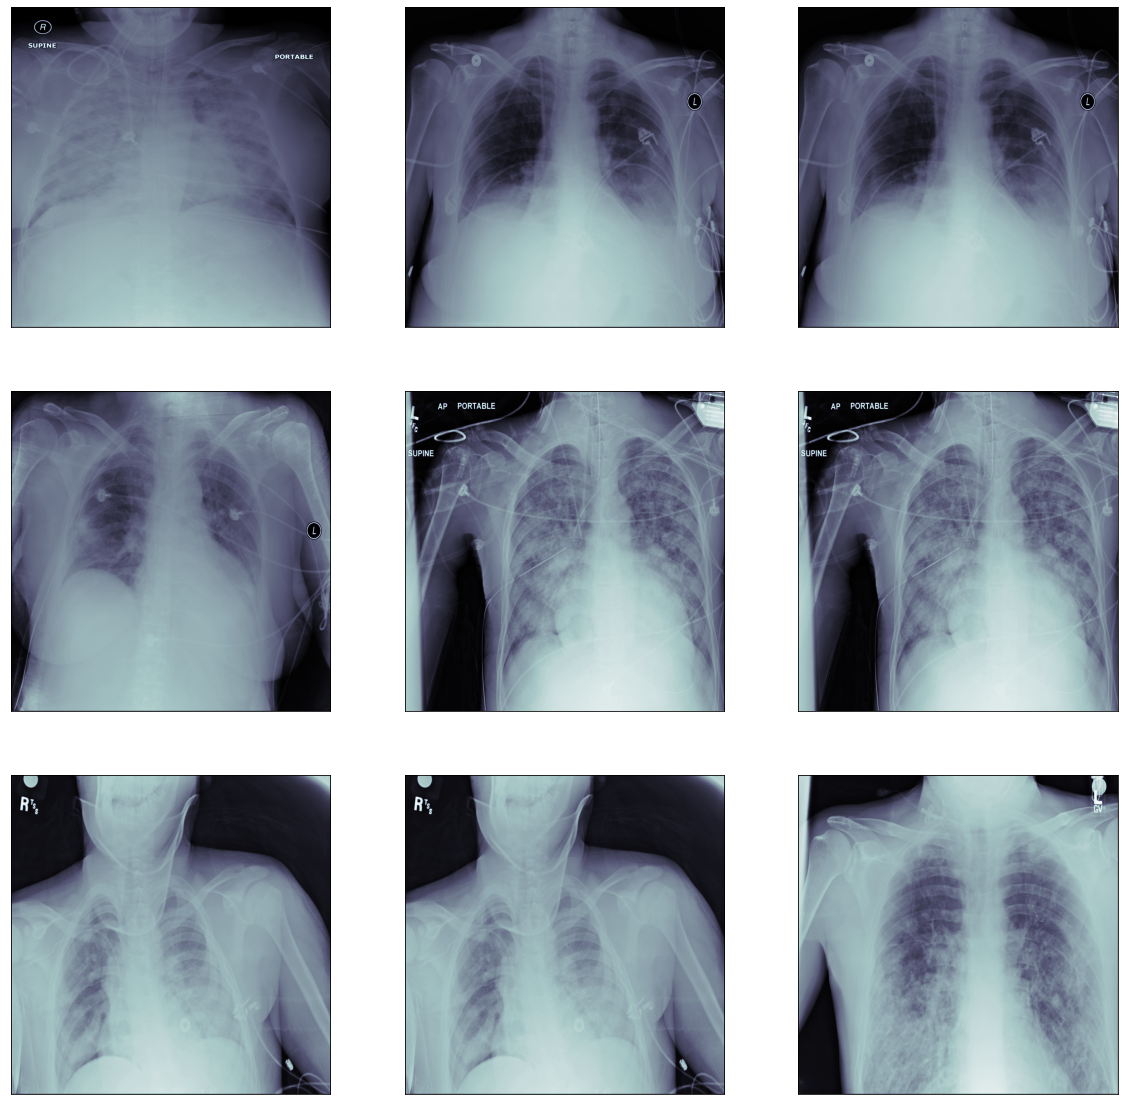

In [40]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(20,20))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap='bone')

imshow()

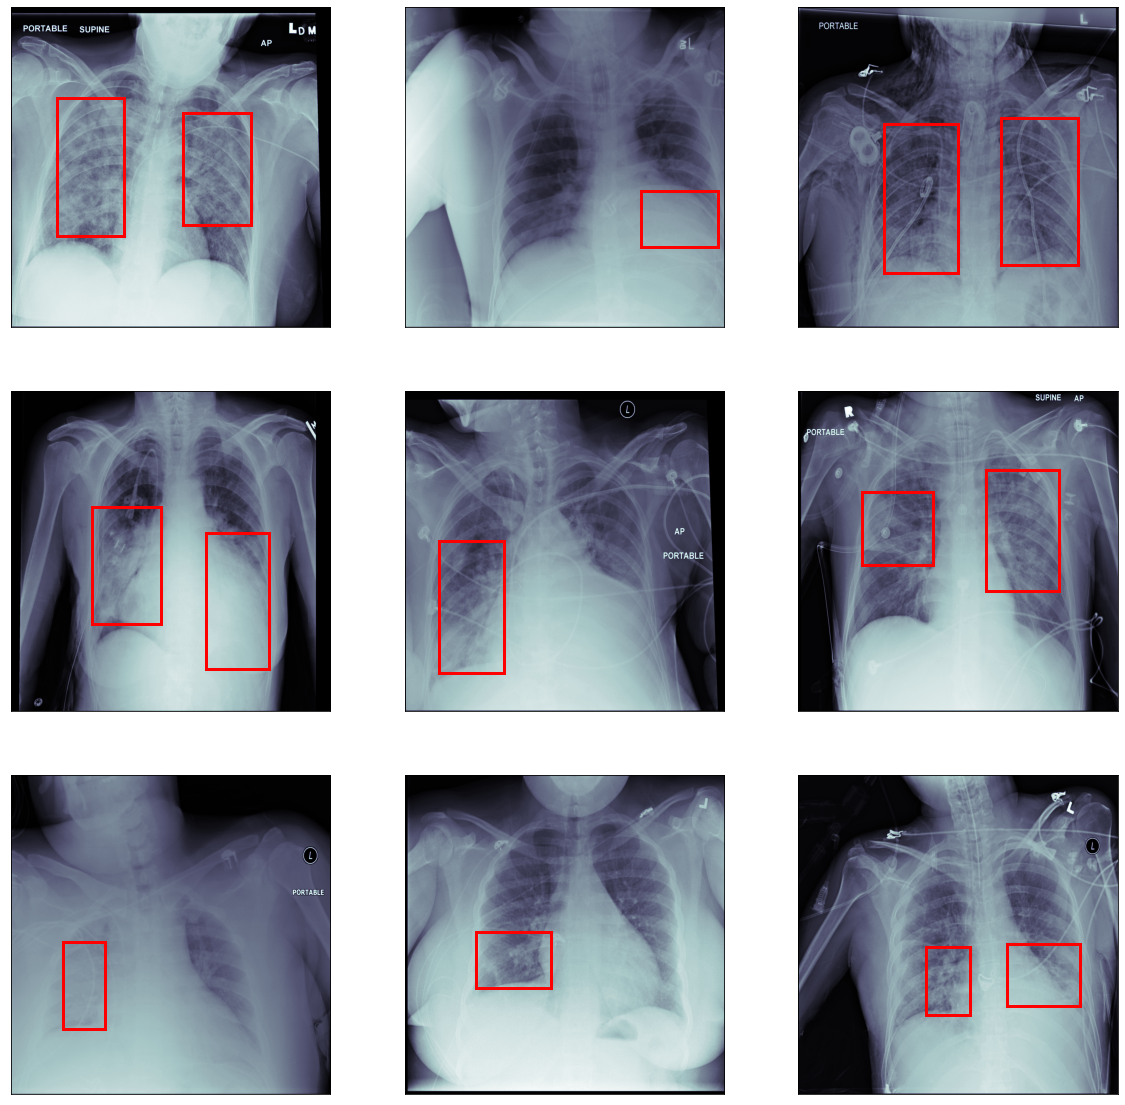

In [41]:
def show_image_with_bboxes(num_to_show=9):
    plt.figure(figsize=(20,20))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        id_= np.random.choice(train_labels_df_pos['patientId'].values)

        current_axis = plt.gca()
        img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
        plt.imshow(img,cmap='bone')


        current_axis = plt.gca()
        boxes=train_labels_df_pos[['x','y','width','height']][train_labels_df_pos['patientId']==id_].values

        for box in boxes:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            current_axis.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3)) 
        
show_image_with_bboxes()

In [42]:
def parse_one_annot(data, patient_id):
    boxes_array = data[data["patientId"] == patient_id][["x", "y", "width", "height"]].values
#     print(boxes_array.dtype)
    return boxes_array

In [43]:
def show_one_with_bbox(id_):
    plt.figure(figsize=(20,20))
    current_axis = plt.gca()
    img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
    plt.imshow(img,cmap='bone')

    current_axis = plt.gca()
    boxes=train_labels_df_pos[['x','y','width','height']][train_labels_df_pos['patientId']==id_].values
    for box in boxes:
        x=box[0]
        y=box[1]
        w=box[2]
        h=box[3]
        current_axis.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3)) 

Id 05d3817a-5535-4e77-8dda-d4412e496c81
Bboxes [[256.  73. 274. 682.]
 [614.  78. 276. 759.]]


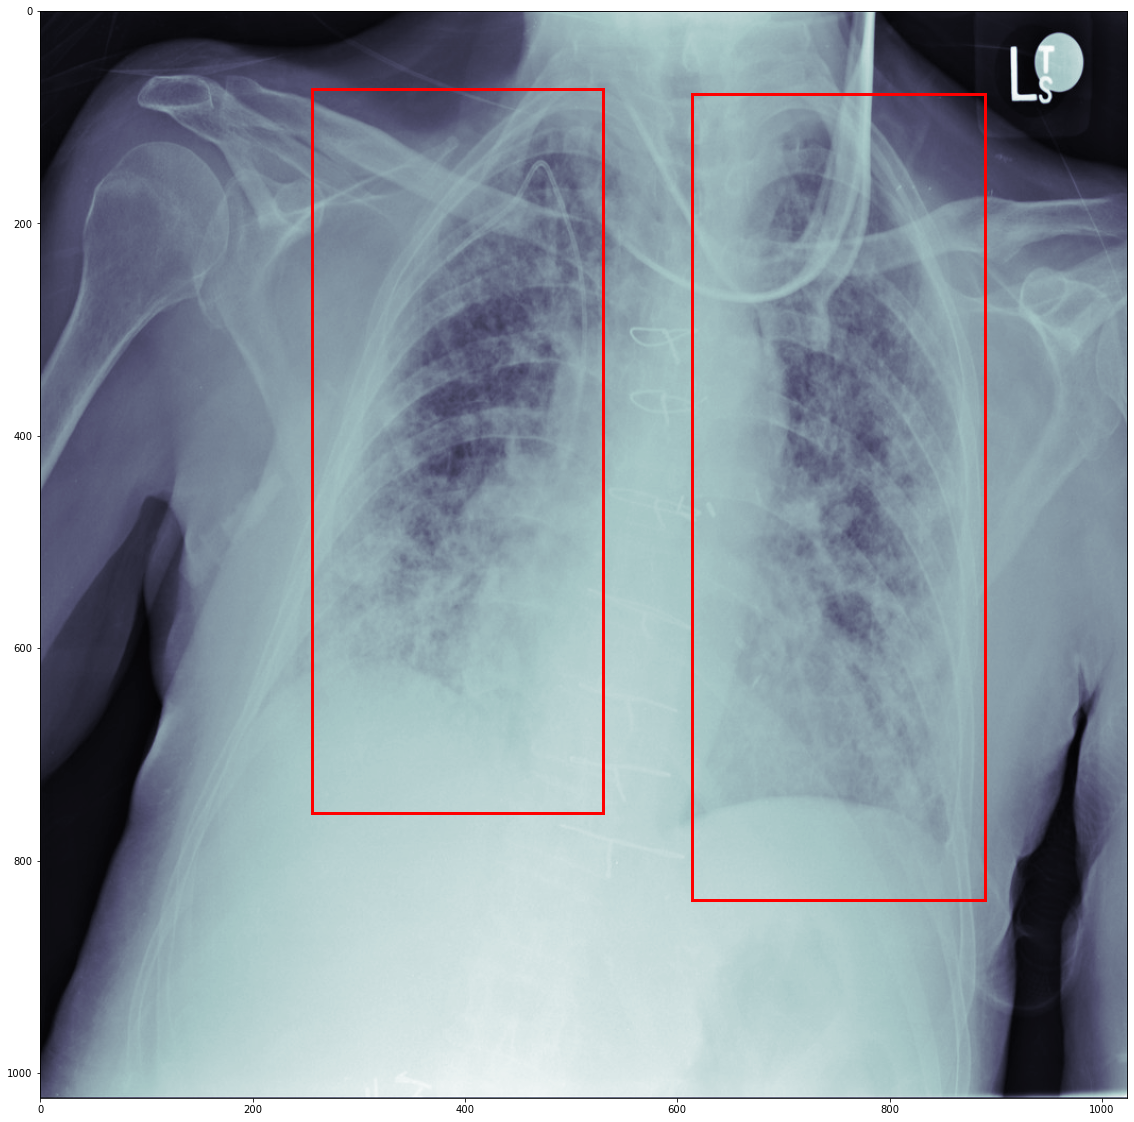

In [44]:
id_= np.random.choice(train_labels_df_pos['patientId'].values)
print('Id', id_)
print('Bboxes', parse_one_annot(train_labels_df_pos, id_))
show_one_with_bbox(id_)

# **Preparing data for training. Dataset class. Tranformations**

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['patientId'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        # load images and bounding boxes   
        image_id = self.image_ids[index]
        records = self.df[self.df['patientId'] == image_id]
        
#         img_path = os.path.join(self.image_dir, image_id) #
#         img=pyd.read_file(os.path.join(img_path+'.dcm')).pixel_array #
        img = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
#         img = img/255 #
        img /= 255.0
        
        boxes = records[['x', 'y', 'width', 'height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}    
        target['boxes'] = boxes
        target['labels'] = labels
        target['patientId'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
                      
        if self.transforms:
            sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            img = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.FloatTensor, zip(*sample['bboxes'])))).permute(1, 0)
            
        return img, target
    

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        Resize(500,  500),
        A.Flip(0.5),
#         A.RandomRotate90(0.5),
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# **Train and Validation split**

In [ ]:
input_folder = 'clache_data/train'
images_folder = f"{input_folder}"

image_ids = train_labels_df_pos['patientId'].unique()
valid_ids = image_ids[-1:]
train_ids = image_ids[:-1]
print(f"Training instance: {len(train_ids)}")
print(f"Validation instances: {len(valid_ids)}")

valid_df = train_labels_df_pos[train_labels_df_pos['patientId'].isin(valid_ids)]
train_df = train_labels_df_pos[train_labels_df_pos['patientId'].isin(train_ids)]

print('Train dataframe shape:', train_df.shape)
print('Valid dataframe shape:', valid_df.shape)
    
train_dataset = PneumoniaDataset(train_df, images_folder, get_train_transform())
valid_dataset = PneumoniaDataset(valid_df, images_folder, get_valid_transform())
# train_dataset = PneumoniaDataset(train_df, images_path, get_train_transform())
# valid_dataset = PneumoniaDataset(valid_df, images_path, get_valid_transform())
print('train_dataset and valid_dataset are loaded :)')   
print("We have: {} training examples and {} validation examples".format(len(train_dataset), len(valid_dataset)))

# **Data Loaders**

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)
valid_data_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

# **Helper functions**

In [ ]:
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision


def calculate_iou(gt, pr, form='pascal_voc') -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    # https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

# **Train and Validate functions**

In [ ]:
def train(dataloader, lr_scheduler, model, optimizer, 
          device, epoch, loss_hist, itr):
    model.train()
    start = time.time()
    loss_hist.reset()
    for images, targets in dataloader:
        
#         images = list(image.to(device) for image in images)
        images = list(image.to(device, dtype=torch.float) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)


        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 100 == 0:
            print(f"Epoch #{epoch} iteration #{itr} loss: {loss_value}")

        itr += 1
    
    end = time.time()
    return loss_hist, end, start

In [ ]:
def validate(dataloader, model, device, iou_thresholds):
    valid_image_precision = []
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:

#             images = list(image.to(device) for image in images)
            images = list(image.to(device, dtype=torch.float) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        gt_boxes = targets[i]['boxes'].cpu().numpy()
        preds_sorted_idx = np.argsort(scores)[::-1]
        preds_sorted = boxes[preds_sorted_idx]
        image_precision = calculate_image_precision(preds_sorted,
                                                        gt_boxes,
                                                        thresholds=iou_thresholds,
                                                        form='coco')
        valid_image_precision.append(image_precision)

    valid_prec = np.mean(valid_image_precision)
    return valid_prec

# **Load the model**

In [ ]:
def get_model():
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=1024)
    # one class is pneumonia, and the other is background
    num_classes = 2
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
    return model

# **Train the model**

In [ ]:
torch.cuda.is_available()

In [ ]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda:2') if torch.cuda.is_available() else torch.device('cpu')

# learning parameters
num_epochs = 100
lr = 0.001
batch_size = 8

model = get_model().to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

# initialize the Averager
loss_hist = Averager()
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

# Checkpoints dir
train_id = '9_size500_dropped_noRotate90_clahe'
ckpt_dir = f'checkpoints/{train_id}'

In [ ]:
train_loss = []
precision = []
for epoch in range(num_epochs):
    itr = 1
    train_loss_hist, end, start = train(train_data_loader, lr_scheduler,
                                        model, optimizer, device,
                                        epoch, loss_hist, itr)
    valid_prec = validate(valid_data_loader, model, device, iou_thresholds)
    print(f"Took {(end-start)/60:.3f} minutes for epoch# {epoch} to train")
    print(f"Epoch #{epoch} Train loss: {train_loss_hist.value}")  
    print(f"Epoch #{epoch} Validation Precision: {valid_prec}")  
    train_loss.append(train_loss_hist.value)
    precision.append(valid_prec)
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    torch.save(model.state_dict(), f'{ckpt_dir}/fasterrcnn_resnet50_fpn_pneumonia_detection_e{epoch}.pth')



# **Plot Loss and Precision**

In [ ]:
# plot the training loss
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.legend()
plt.show()

# plot the validation precision
plt.figure()
plt.plot(precision, label='Validation precision')
plt.legend()
plt.show()

# **Test model and make predictions**

In [ ]:
#uncomment next cells in case of testing
#commented due to lack of memory

In [ ]:
device = torch.device('cuda:2') if torch.cuda.is_available() else torch.device('cpu')

# input_folder = '../input/rsna-pneumonia-detection-2018/input'
input_folder = 'clache_data/test'

images_test_path = f"{input_folder}"
test_images = os.listdir(images_test_path)
print(f"Validation instances: {len(test_images)}")

In [ ]:
# # load a model; pre-trained on COCO
model = get_model()

# os.makedirs('../validation_predictions', exist_ok=True)
model.load_state_dict(torch.load('checkpoints/9_size500_dropped_noRotate90_clahe/fasterrcnn_resnet50_fpn_pneumonia_detection_e199.pth'))
model.to(device)

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], 
                                                             int(j[1][0]), int(j[1][1]), 
                                                             int(j[1][2]), int(j[1][3])))

    return " ".join(pred_strings)

In [ ]:
# detection_threshold = 0.8
detection_threshold = 0.8


img_num = 0
results = []
model.eval()
with torch.no_grad():
    for i, image in tqdm(enumerate(test_images), total=len(test_images)):

        orig_image = cv2.imread(f"{images_test_path}/{test_images[i]}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float)
        image = torch.tensor(image, dtype=torch.float).cuda(2)
        image = torch.unsqueeze(image, 0)

        model.eval()
        cpu_device = torch.device("cpu")

        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        if len(outputs[0]['boxes']) != 0:
            for counter in range(len(outputs[0]['boxes'])):
                boxes = outputs[0]['boxes'].data.cpu().numpy()
                scores = outputs[0]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
                
#             for box in draw_boxes:
#                 print((int(box[0]), int(box[1])),
#                             (int(box[2]), int(box[3])))
#                 cv2.rectangle(np.array(img.cpu()),
#                             (int(box[0]), int(box[1])),
#                             (int(box[2]), int(box[3])),
#                             (0, 0, 255), 3)
        
#             plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
#             plt.axis('off')
#             plt.savefig(f"{test_images[i]}")
#             plt.close()
                
            result = {
                'patientId': test_images[i].split('.')[0],
                'PredictionString': format_prediction_string(boxes, scores)
            }
            results.append(result)
        else:
            result = {
                'patientId': test_images[i].split('.')[0],
                'PredictionString': None
            }
            results.append(result)

sub_df = pd.DataFrame(results, columns=['patientId', 'PredictionString'])
print(sub_df.head())
sub_df.to_csv('4_submission.csv', index=False)